Max transmitted amplitude:  0.23474914285728474 V
Average transmitted power:  -1.0827697177653497 dBm


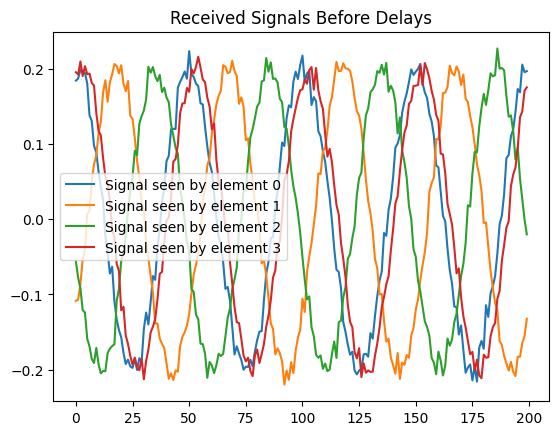

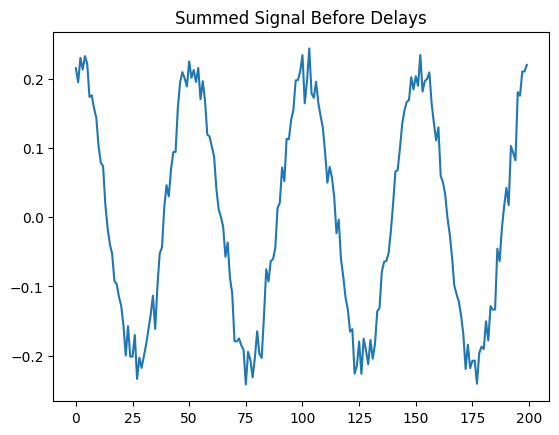

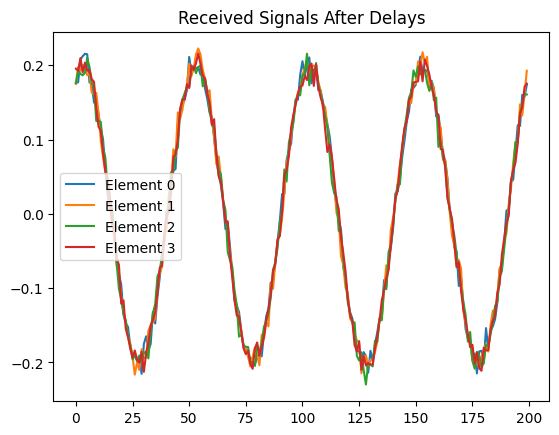

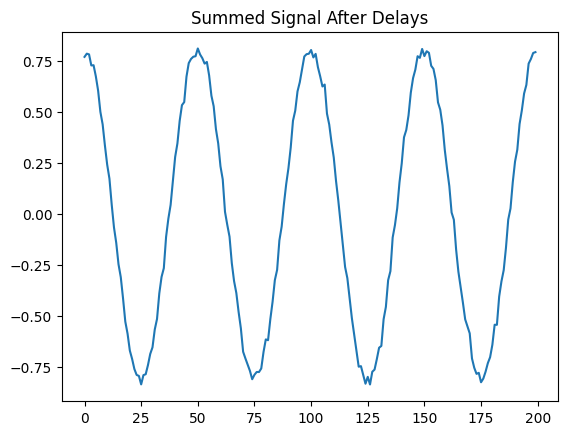

Max received amplitude:  0.8509165139031178 V
Average received power:  8.597739043529486 dBm
Gain due to beamforming: 11.185658739614741 dB
[[ 1.84280836e-01+0.01349314j  1.87178259e-01+0.00963967j
   1.98535553e-01+0.06342749j ...  1.89730218e-01-0.09967146j
   1.90924940e-01-0.04531968j  1.85527588e-01-0.03053808j]
 [-1.08450965e-01-0.1514035j  -1.06929388e-01-0.17564667j
  -8.58746468e-02-0.17634294j ... -1.63231781e-01-0.10699332j
  -1.54584338e-01-0.1372687j  -1.26107240e-01-0.15207072j]
 [-5.60595290e-02+0.1788217j  -7.77716117e-02+0.18358608j
  -9.20065747e-02+0.16678629j ...  1.37205641e-02+0.20075293j
  -5.38035369e-06+0.21066772j -2.06971364e-02+0.19696832j]
 [ 1.95540159e-01-0.08147825j  1.92551723e-01-0.04628927j
   2.09719067e-01-0.02941687j ...  1.48138642e-01-0.15142438j
   1.57622150e-01-0.12744068j  1.79259049e-01-0.09938596j]]
[ 0.04113211+0.42519658j  0.02378431+0.41516169j -0.01731544+0.43597359j
 ...  0.21854392+0.35949917j  0.18788175+0.43005742j
  0.11167864+0.41

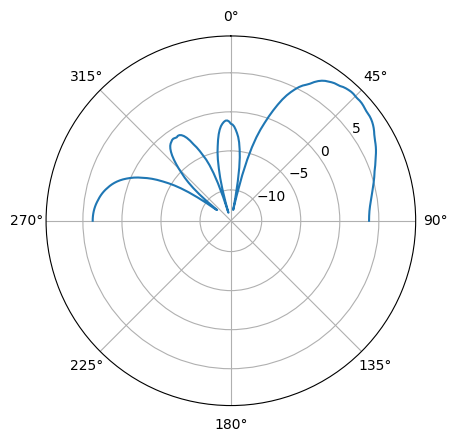

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

sample_rate = 1e6
N = 10000 # number of samples to simulate
d = 0.5 # half wavelength spacing
Nr = 4 # number of elements
theta_degrees = 45 # angle of arrival (feel free to change this, it's arbitrary)
theta = theta_degrees / 180 * np.pi # convert to radians

# Create 4 tones to simulate signals being seen by each element
t = np.arange(N)/sample_rate # time vector
f_tone = 0.02e6 # carrier frequency
signal = .2*np.exp(2j * np.pi * f_tone * t)

# Calculate beamforming weights using angle of arrival theta and element spacing
b_0 = np.exp(-2j * np.pi * d * 0 * np.sin(theta)) # array factor
b_1 = np.exp(-2j * np.pi * d * 1 * np.sin(theta)) # array factor
b_2 = np.exp(-2j * np.pi * d * 2 * np.sin(theta)) # array factor
b_3 = np.exp(-2j * np.pi * d * 3 * np.sin(theta)) # array factor

# Simulate delay between the 4 received signals
tx = []
tx.append(signal * b_0)
tx.append(signal * b_1)
tx.append(signal * b_2)
tx.append(signal * b_3)

# Introduce noise
n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
tx = tx + 0.01*n # r and n are both 3x10000

max_amplitude = []
for i in range(0, len(tx)):
    max_amplitude.append(np.asarray(tx[i]).squeeze().real[np.argmax(np.asarray(tx[i]).squeeze().real)])

max_transmitted_amplitude = max_amplitude[np.argmax(max_amplitude)]
print("Max transmitted amplitude: ", max_transmitted_amplitude, "V")
average_transmitted_power = 10*np.log10((((np.square(max_amplitude[np.argmax(max_amplitude)])/np.sqrt(2))/50))/.001)
print("Average transmitted power: ", average_transmitted_power, "dBm")

# Plot signals seen by each individual element
plt.plot(np.asarray(tx[0]).squeeze().real[0:200], label="Signal seen by element 0")
plt.plot(np.asarray(tx[1]).squeeze().real[0:200], label="Signal seen by element 1")
plt.plot(np.asarray(tx[2]).squeeze().real[0:200], label="Signal seen by element 2")
plt.plot(np.asarray(tx[3]).squeeze().real[0:200], label="Signal seen by element 3")
plt.title("Received Signals Before Delays")
plt.legend()
plt.show()

# Multiply received signal data by beamforming weights
rx = []
rx.append(b_3*tx[0])
rx.append(b_2*tx[1])
rx.append(b_1*tx[2])
rx.append(b_0*tx[3])

# Plot summation of signals before beamforming weights applied
unbeamformed_signal = np.asarray(tx[0]).squeeze().real[0:200] + np.asarray(tx[1]).squeeze().real[0:200] + np.asarray(tx[2]).squeeze().real[0:200] + np.asarray(tx[3]).squeeze().real[0:200]
plt.plot(unbeamformed_signal, label="Summed")
plt.title("Summed Signal Before Delays")
plt.show()

# Plot signal data after beamforming weights applied
plt.plot(np.asarray(rx[0]).squeeze().real[0:200], label="Element 0")
plt.plot(np.asarray(rx[1]).squeeze().real[0:200], label="Element 1")
plt.plot(np.asarray(rx[2]).squeeze().real[0:200], label="Element 2")
plt.plot(np.asarray(rx[3]).squeeze().real[0:200], label="Element 3")
plt.title("Received Signals After Delays")
plt.legend()
plt.show()


b = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # array factor
summed_signal = b.conj().T @ tx

# Plot summed signal after beamforming weights
# summed_signal = np.asarray(rx[0]).squeeze().real + np.asarray(rx[1]).squeeze().real + np.asarray(rx[2]).squeeze().real + np.asarray(rx[3]).squeeze().real
summed_signal = np.asarray(summed_signal).squeeze().real
plt.plot(summed_signal[0:200], label="Summed")
plt.title("Summed Signal After Delays")
plt.show()

max_received_amplitude = summed_signal[np.argmax(summed_signal)]
print("Max received amplitude: ", max_received_amplitude, "V")
average_received_power = 10*np.log10((np.square(summed_signal[np.argmax(summed_signal)]/np.sqrt(2))/50)/.001)
print("Average received power: ", average_received_power, "dBm") 
print("Gain due to beamforming:", 20*np.log10(max_received_amplitude/max_transmitted_amplitude), "dB")

# Plot error between received and original signal
# plt.plot(abs((summed_signal[0:200]/4) - np.asarray(tx[3]).squeeze().real[0:200]), label="Error")
# average_error = sum( abs((summed_signal[0:200]/4) - np.asarray(tx[3]).squeeze().real[0:200]) ) /200
# plt.axhline(average_error, color='r', label="Average Error")
# plt.legend()
# plt.title("Error")
# plt.show()
# print("Average Error: ", 100*average_error, "%")

theta_scan_rad = np.linspace(-np.pi/2, np.pi/2, 181) # 1000 different thetas between -180 and +180 degrees
theta_scan = list(range(-90, 91))
# print("theta_scan: ", theta_scan)
# print(theta_scan[theta_degrees+90]*180/np.pi)
# print("theta_degrees: ", theta_degrees)
results = []
for theta_i in theta_scan:
   theta_rad = theta_i / 180 * np.pi
   w = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_rad)) # Conventional, aka delay-and-sum, beamformer
   r_weighted = w.conj().T @ tx # apply our weights.
   results.append(10*np.log10((np.square(np.asarray(r_weighted).squeeze().real[np.argmax(np.asarray(r_weighted).squeeze().real)]/np.sqrt(2))/50)/.001)) # power in signal, in dB so its easier to see small and large lobes at the same time
# results -= np.max(results) # normalize
print(tx)
print(r_weighted)
# angle that gave us the max value
detected_angle = theta_scan[np.argmax(results)]

print("Detected angle:", detected_angle, "degrees")
print("Steering angle:", theta_degrees, "degrees")
print("Average power at detected angle:", results[np.argmax(results)], "dBm")
print("Average power at steering angle:", results[theta_degrees+90], "dBm")
print("Detected angle and steering angle differ by", abs(theta_degrees-detected_angle), "degree(s).")
print("Error:", 100*abs(1-(detected_angle/theta_degrees)), "%")

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_scan_rad, results) # MAKE SURE TO USE RADIAN FOR POLAR
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
plt.show()

